inspired by: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/ViTMAE/ViT_MAE_visualization_demo.ipynb

# Visualization demo: Distillation with no Labels (DINO)

In this notebook, we are going to visualize some predictions of a Vision Transformer (ViT) pre-trained on self-distillation with no labels. The student tries to predict teacher-produced pseudolabels for local crops of an image(as shown in the figure below).

<img src="https://github.com/facebookresearch/dino/raw/main/.github/dino.gif" width="600" class="center"/>

* Paper: https://arxiv.org/abs/2104.14294
* Original repo: https://github.com/facebookresearch/dino
* Interactive demo: https://ssl-demos.metademolab.com/

## Set-up environment

In [1]:
#!pip install -q git+https://github.com/huggingface/transformers.git

## Prepare image

Here we apply some very basic image processing, namely resizing to 224x224 and normalizing the channels.

Image size: (640, 400)


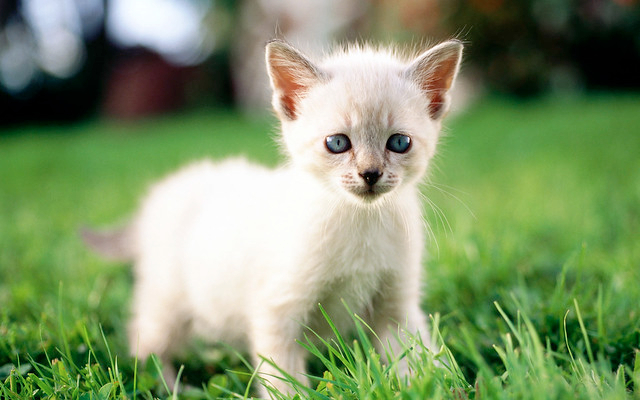

In [2]:
import requests
from PIL import Image

url = "https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg"
#image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('cat.png').convert('RGB')
print(f'Image size: {image.size}')
image

## Visualization

Next, we forward the pixel values through the model. The encoder (which is a standard Vision Transformer) will first encode the visual patches.

In [3]:
import torch
import torch.nn as nn
import numpy as np
from transformers import ViTFeatureExtractor

torch.manual_seed(2)

model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
#model = torch.hub.load('facebookresearch/dino:main', 'dino_vitb16')

# Use huggingface feature extractor for preprocessing
feature_extractor = ViTFeatureExtractor(
    do_resize = True,
    size = (224,224),
    do_normalize=True,
    image_mean = [0.485, 0.456, 0.406], # imagenet mean
    image_std = [0.229, 0.224, 0.225] # imagenet std
)

# adjust to return embeddings, source:
# https://github.com/facebookresearch/dino/blob/cb711401860da580817918b9167ed73e3eef3dcf/vision_transformer.py#L209
def forward(x):
    x = model.prepare_tokens(x)
    for blk in model.blocks:
        x = blk(x)
    x = model.norm(x)
    return x # x[:, 0] is [CLS] embedding
model.forward = forward

print(model)

/home/felix/miniconda3/envs/cil/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/felix/.cache/torch/hub/facebookresearch_dino_main
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth" to /home/felix/.cache/torch/hub/checkpoints/dino_vitbase16_pretrain.pth
100%|██████████| 327M/327M [01:24<00:00, 4.05MB/s] 


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

### Visualizing the Attention

In [4]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def denormalize(image):
    imagenet_mean = np.array(feature_extractor.image_mean)
    imagenet_std = np.array(feature_extractor.image_std)
    return image * imagenet_std + imagenet_mean

def show_image(image, title=''):
    # image is [H, W, 3] or [H, W, 1]
    plt.imshow(torch.clip(image * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def show_mask(mask, title=''):
    # image is [H, W, 3] or [H, W]
    plt.imshow(mask)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize_att(img, model):

    # prepare model
    patch_size = model.patch_embed.patch_size
    for p in model.parameters():
        p.requires_grad = False
    model.eval()


    print(f'img.shape: {img.shape}')
    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    # forward pass
    attentions = model.get_last_selfattention(img) # [n_batches, n_heads, n_emb_att_to, n_emb_att_from]
    attentions = attentions[0, :, 0, 1:] # we keep only the output patch attention for [CLS]
    nh = attentions.shape[0] # number of head

    # convert to [n_heads, n_channels, with, height]
    attentions = attentions.reshape(nh, 1, w_featmap, h_featmap)
    mask = F.interpolate(attentions, scale_factor=patch_size, mode="nearest")

    # transpose channels to back
    x = torch.einsum('nchw->nhwc', img)[0]
    mask = torch.einsum('nchw->nhwc', mask)
    
    # map to RGB colorspaces
    x = denormalize(x)
    max_attn = mask.amax(dim=(1,2,3), keepdim=True)
    mask = mask.repeat(1,1,1,3) / max_attn

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 6]
    plt.suptitle('Last-layer attention of [CLS] token', fontsize=26)

    plt.subplot(2, nh+1, 1)
    show_image(x, "original")

    plt.subplot(2, nh+1, nh+1 + 1)
    show_image(x, "original")

    max_attn = max_attn.squeeze()
    for j in range(nh):    
        plt.subplot(2, nh+1, j+2)
        show_image(x * mask[j], f"head {j}")

        plt.subplot(2, nh+1, nh+1 + j+2)
        show_image(mask[j], f"max_att={max_attn[j]:.3f}")


    plt.show()

img.shape: torch.Size([1, 3, 224, 224])


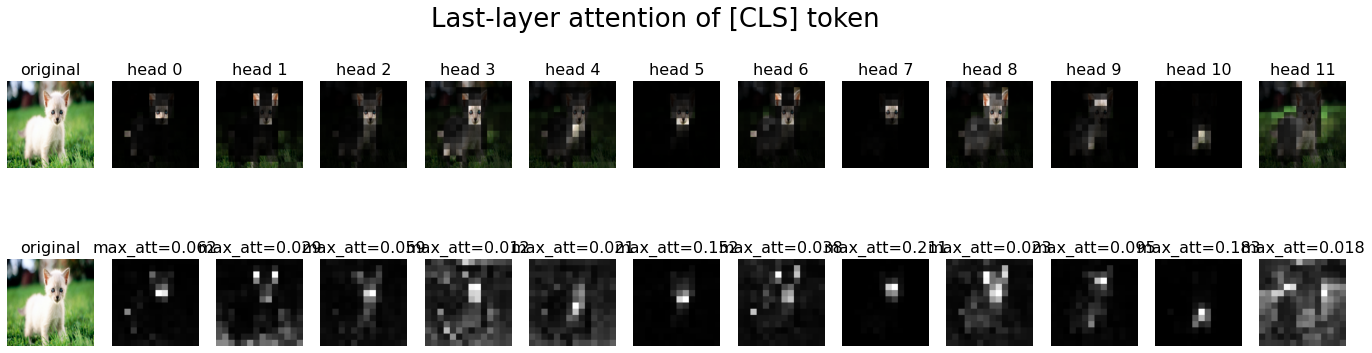

In [5]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize_att(pixel_values, model)

### Visualize within-image PCA of patch embeddings



In [6]:
from sklearn.decomposition import PCA

def map_cmap(bw, cmap_name):
    cmap = plt.get_cmap(cmap_name)
    norm = plt.Normalize()
    
    # image is [H, W, 1]
    img_rgba = cmap(norm(bw[:,:,0]))
    img_rgb = img_rgba[:,:,:3]
    return torch.from_numpy(img_rgb)

def map_gray(img):
    # image is [H, W, 3]
    coeff = torch.tensor([0.21626, 0.7152, 0.0722], dtype=torch.float64)
    return img.matmul(coeff).unsqueeze(-1)



def visualize_emb(img, model):
    img = feature_extractor(image, return_tensors="pt").pixel_values

    # prepare model
    patch_size = model.patch_embed.patch_size
    for p in model.parameters():
        p.requires_grad = False
    model.eval()

    print(f'img.shape: {img.shape}')
    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    # forward pass
    output = model(img) # [n_batches, n_embeddings, n_channels]
    output = output[0, 1:, :] # keep only patch embeddings, discard [CLS] embedding

    # use first principal coponent for colorgrading
    pc = torch.from_numpy(PCA(n_components=1).fit_transform(output))

    # convert to [n_heads, n_channels, with, height]
    pc = pc.reshape(1, 1, w_featmap, h_featmap)
    cmask = F.interpolate(pc, scale_factor=patch_size, mode="nearest")

    # transpose channels to back
    x = torch.einsum('nchw->nhwc', img)[0]
    cmask = torch.einsum('nchw->nhwc', cmask)[0]

    # map to RGB colorspaces
    x = denormalize(x)
    cmask = map_cmap(cmask, 'jet')

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 6]
    plt.suptitle('Within-image PCA of patch embeddings', fontsize=26)


    plt.subplot(1,2,1)
    show_image(x, 'original')

    plt.subplot(1,2,2)
    show_image((cmask + x)/2, "principal component")


    plt.show()



img.shape: torch.Size([1, 3, 224, 224])


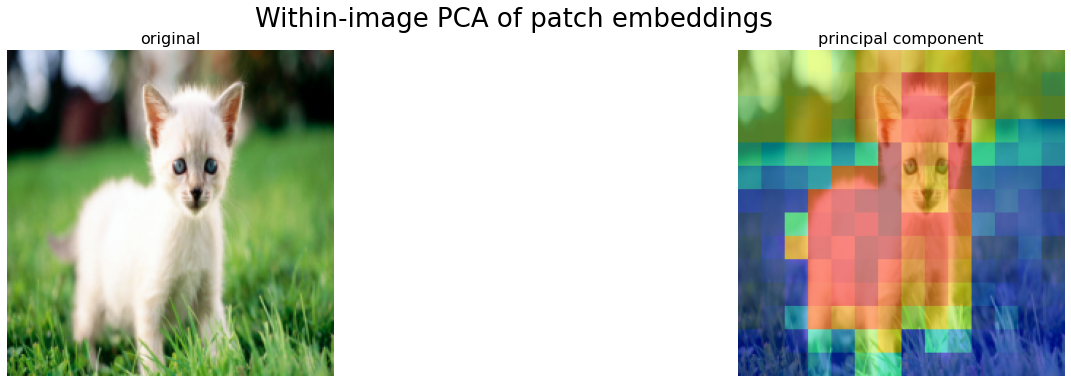

In [7]:
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize_emb(pixel_values, model)

## Change Input Image Size to Original Image size

The model works out of the box with differently sized images. No code changes required here. 

img.shape: torch.Size([1, 3, 400, 640])


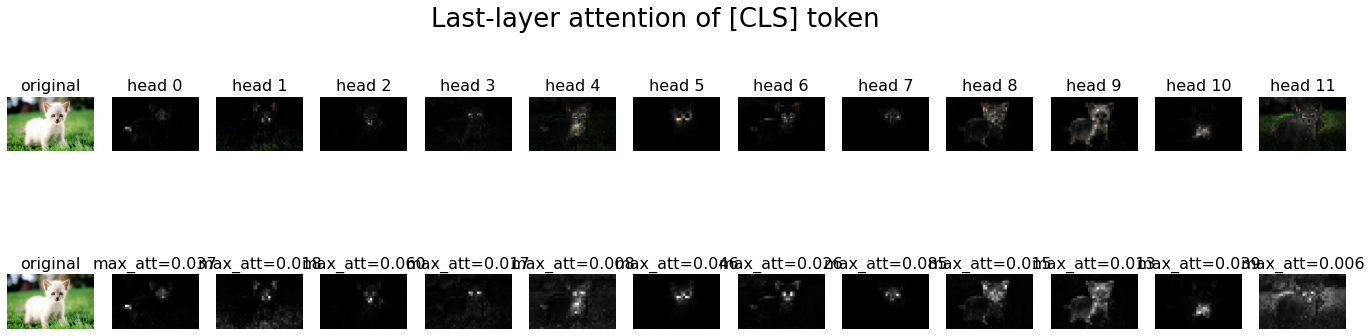

img.shape: torch.Size([1, 3, 400, 640])


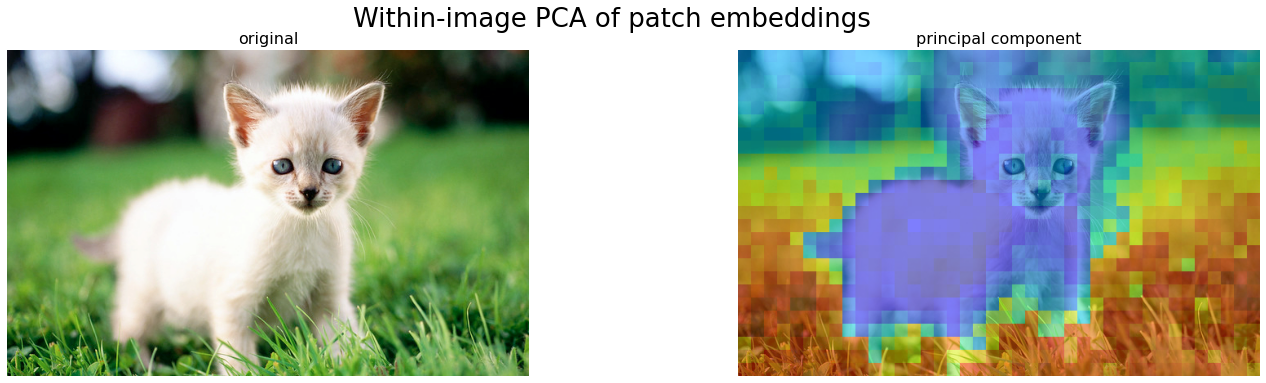

In [8]:
feature_extractor.do_resize = False
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize_att(pixel_values, model)
visualize_emb(pixel_values, model)

img.shape: torch.Size([1, 3, 400, 400])


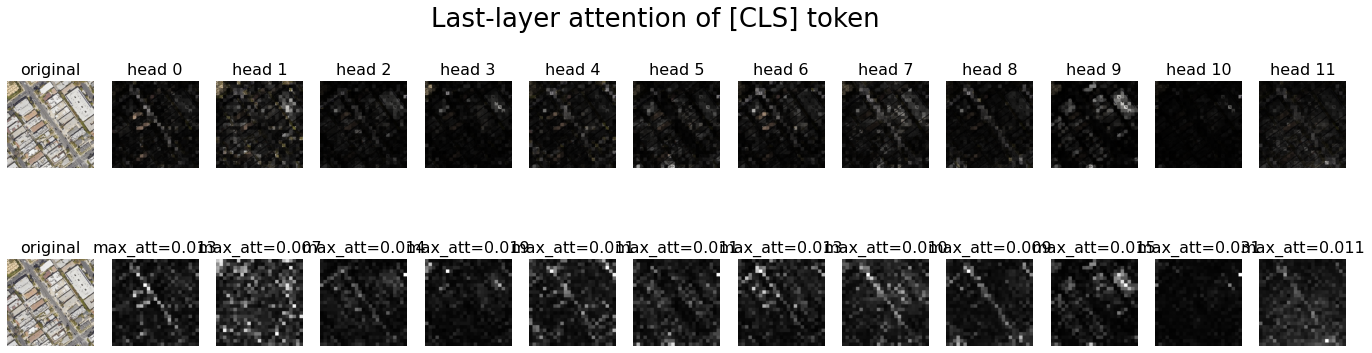

img.shape: torch.Size([1, 3, 400, 400])


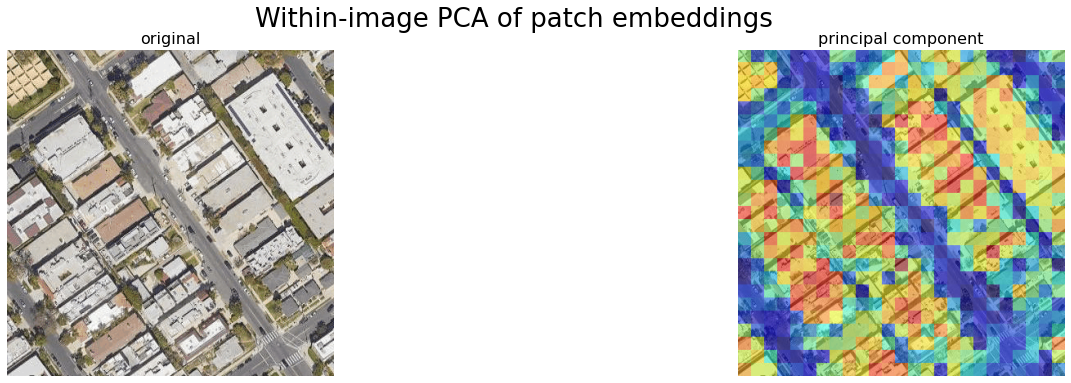

In [9]:
image = Image.open('../cil-data/training/images/satimage_2.png').convert('RGB')
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
visualize_att(pixel_values, model)
visualize_emb(pixel_values, model)

## After pre-training

Fine-tuning and linear probing can be done directly with the model. Instead we use the vit_embeddings module to generate the patchwise embeddings for every image and analyize them using more traditional methods.

In [10]:
%load_ext autoreload
%autoreload 2
from vit_embeddings import *

df = convert_dataset('../cil-data', 'training', 'satimage', 'dino_vits16', image_size=400)
print(f'df.shape = {df.shape}')
df.head()

Using cache found in /home/felix/.cache/torch/hub/facebookresearch_dino_main


Compute embeddings...


100%|██████████| 144/144 [08:00<00:00,  3.34s/it]


Compute ratios...


100%|██████████| 144/144 [00:01<00:00, 129.37it/s]


df.shape = (90000, 770)


,img,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x759,x760,x761,x762,x763,x764,x765,x766,x767,y
0,0,0.060635,-3.729733,2.107088,0.395770,1.918421,-2.564159,0.360731,-1.433845,0.772173,...,-1.331050,-2.198699,1.141379,1.734104,1.488081,-0.171497,-0.581263,0.798846,0.456499,0.0
1,0,0.377187,0.656850,1.944465,0.489769,0.446363,-2.926172,-3.250759,0.694051,2.331298,...,-2.575437,0.703798,1.859272,1.911095,0.933541,-3.365684,0.390388,1.312493,0.202519,0.0
2,0,-0.585721,0.255668,-0.640212,2.469676,1.570318,-2.977910,-2.076308,-0.920805,-1.024039,...,-1.714467,-4.385253,0.978699,2.057338,2.148404,1.535881,-0.348490,2.387441,-1.714118,0.0
3,0,1.084160,2.329527,-0.391064,0.716207,1.349496,-2.366612,-0.565766,-0.155983,-1.404576,...,-1.869809,0.145998,1.288214,2.118493,-0.153645,2.311367,-0.412608,-0.592995,-1.942896,0.0
4,0,0.260373,3.055449,1.361887,0.293991,-0.226127,-2.580595,-0.648089,-4.073352,-0.138072,...,0.254565,-5.647310,1.486632,1.575544,-2.775394,2.233756,-0.250469,1.051777,-4.729675,0.0


In [11]:
# extract embeddings and labels
lbls = df['y']
embs = df.drop(['y', 'img'], axis='columns')

#### Labels: road-ratio per patch

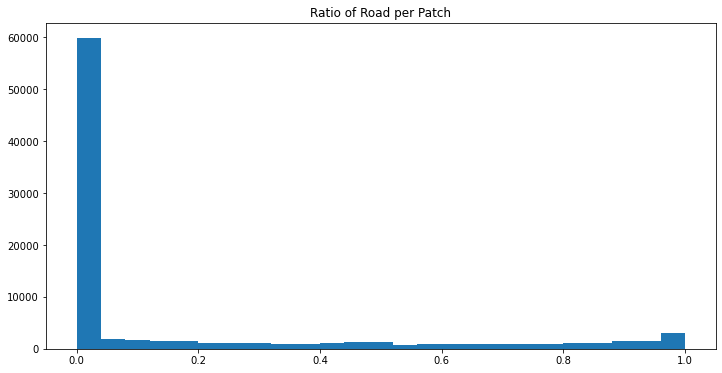

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
from sklearn.decomposition import PCA

plt.hist(lbls, bins = 25)
plt.title('Ratio of Road per Patch')
plt.show()


#### Features: Patchwise ViT embeddings

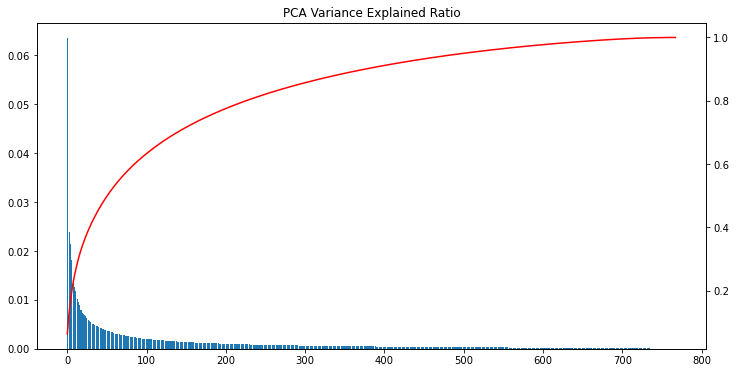

In [13]:
pca = PCA().fit(embs)
x_pca = pca.transform(embs)

indices = range(pca.n_components_)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 

ax1.bar(indices, pca.explained_variance_ratio_)
ax2.plot(indices, np.cumsum(pca.explained_variance_ratio_), c='r')
plt.title('PCA Variance Explained Ratio')
plt.show()

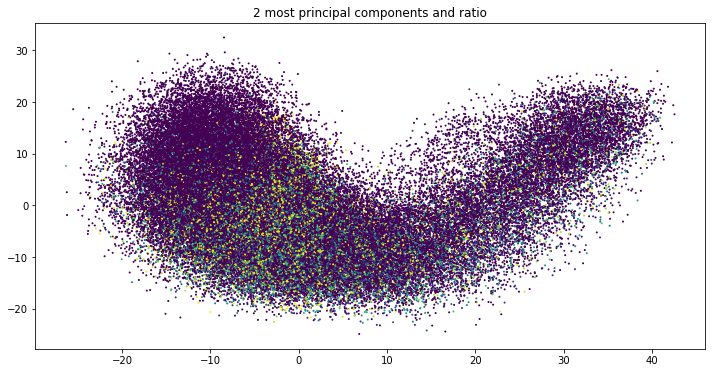

In [14]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=lbls, s=1)
plt.title('2 most principal components and ratio')
plt.show()

### Logistic Regression on binary labels

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X = scaler.fit_transform(embs)
y = pd.Series(lbls > 0.25)

folds = StratifiedKFold(n_splits=5)
for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, X_val = X[train_idx, :], X[val_idx, :]
    y_train, y_val = y[train_idx], y[val_idx]

    clf = LogReg(class_weight='balanced', max_iter=1e5)
    clf.fit(X_train, y_train)

    acc_train = accuracy_score(y_train, clf.predict(X_train))
    acc_val = accuracy_score(y_val, clf.predict(X_val))
    print(f'Split {i}: train={acc_train:.3f}, val={acc_val:.3f}')

Split 0: train=0.816, val=0.817
Split 1: train=0.819, val=0.788


KeyboardInterrupt: 

#### Use softlabels: linear regression on logits

This is a very bad workaround which should be much easier to implement in pytorch with a cross-entropy loss between the prediction and the soft labels. Unfortunately this is not available in sklearn and I just wanted to quickly try it. 

In [ ]:
from scipy.special import logit, expit

eps = 1e-4
X = scaler.fit_transform(embs[lbls>0])
y = np.array(lbls[lbls>0].clip(eps, 1-eps).apply(logit))
plt.hist(y, bins = 100)

print(f'y.shape: {y.shape}')
print(f'X.shape: {X.shape}')

In [ ]:
from sklearn.linear_model import LinearRegression as LinReg

def log_accuracy(y_true, y_pred, thresh=0.25):
    y_true = expit(y_true) > thresh
    y_pred = expit(y_pred) > thresh
    return accuracy_score(y_true, y_pred)

folds = KFold(n_splits=5)
for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    X_train, X_val = X[train_idx, :], X[val_idx, :]
    y_train, y_val = y[train_idx], y[val_idx]

    clf = LinReg() # minimizes MSE in logit space
    clf.fit(X_train, y_train)

    acc_train = log_accuracy(y_train, clf.predict(X_train))
    acc_val = log_accuracy(y_val, clf.predict(X_val))
    print(f'Split {i}: train={acc_train:.3f}, val={acc_val:.3f}')